# Iniciar Sessão Spark

import os
## Set up environment variables
os.environ['JAVA_HOME'] = r'C:\Program Files\Java\jdk-21'
os.environ['SPARK_HOME'] = r'C:\Users\kawda\Downloads\spark-3.5.4-bin-hadoop3\spark-3.5.4-bin-hadoop3'

## Initialize a Spark session
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder \
	.master("local[*]") \
	.config("spark.executor.memory", "8g") \
	.config("spark.driver.memory", "8g") \
	.getOrCreate()

## Verify the Spark session
spark()

# Imports

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from collections import Counter
from boruta import BorutaPy
from scipy import stats

# Dados

In [4]:
# Abrir os dados disponíveis sobre o doenças cardíacas
df_diabetes = pd.read_csv(r'C:\Users\kawda\OneDrive\Desktop\Data_Science\Semana_6\Tarefa\Diabetes\diabetes.csv')
df_diabetes.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


# Data Preparation

## Retirar espaços dos nomes das variáveis e substituir por underscore

In [5]:
# Substituir espaços por underscores nos nomes das colunas
df_diabetes.columns = df_diabetes.columns.str.replace(' ', '_')

# Verificar as primeiras linhas para confirmar a substituição
df_diabetes.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


## Tratamento inicial padrão (Alta porcentagem de nulos, Variáveis constantes, Missings)

In [6]:
def get_metadata(dataframe):
	# Coleta de metadados básicos
	metadata = pd.DataFrame({
		'nome_variavel': dataframe.columns,
		'tipo': dataframe.dtypes,
		'qt_nulos': dataframe.isnull().sum(),
		'percent_nulos': round((dataframe.isnull().sum() / len(dataframe)) * 100, 2),
		'cardinalidade': dataframe.nunique(),
	})

	# Função para testar normalidade usando o teste de Shapiro-Wilk
	def test_normality(series, alpha=0.05):
		if series.dtype in ["float64", "int64", "int32"]:
			statistic, p_value = stats.shapiro(series.dropna())  # dropping NA values for the test
			return p_value > alpha
		else:
			return None  # Return None for non-numeric data types

	# Aplicando teste de normalidade
	metadata["fl_normal"] = dataframe.apply(test_normality)

	metadata = metadata.sort_values(by='percent_nulos', ascending=False)
	metadata = metadata.reset_index(drop=True)

	return metadata

# Apply the function to the dataframe
metadados = get_metadata(df_diabetes)
metadados.head()

,nome_variavel,tipo,qt_nulos,percent_nulos,cardinalidade,fl_normal
0,Pregnancies,int64,0,0.0,17,False
1,Glucose,int64,0,0.0,136,False
2,BloodPressure,int64,0,0.0,47,False
3,SkinThickness,int64,0,0.0,51,False
4,Insulin,int64,0,0.0,186,False


In [7]:
def preprocess_dataframe(df):
	# Drop columns with >80% missing values
	total_count = len(df)
	columns_to_drop = [col for col in df.columns if df[col].isnull().sum() / total_count > 0.8]
	df = df.drop(columns=columns_to_drop)
	
	# Replace missing values
	for col_name in df.columns:
		data_type = df[col_name].dtype
		
		if np.issubdtype(data_type, np.number):
			mean_value = df[col_name].mean()
			df[col_name] = df[col_name].fillna(mean_value)
		elif data_type == object:
			df[col_name] = df[col_name].fillna("Desconhecido")
	
	# Drop columns with variance equals to 0
	numeric_columns = df.select_dtypes(include=[np.number]).columns
	variances = df[numeric_columns].var()
	columns_to_drop = variances[variances == 0].index.tolist()
	df = df.drop(columns=columns_to_drop)
	
	return df

# Apply the function to the dataframe
abt_full = preprocess_dataframe(df_diabetes)
abt_full.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


# Identificar e separar o target e fazer o test-split

In [8]:
# Verificar os dados e separar o target
lista_spec = ['Outcome']
abt_00 = df_diabetes.drop(columns=lista_spec)

# Split the data into train and test sets
abt_01, abt_test = train_test_split(abt_00, test_size=0.2, random_state=88)

abt_01.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
729,2,92,52,0,0,30.1,0.141,22
482,4,85,58,22,49,27.8,0.306,28
507,1,130,60,23,170,28.6,0.692,21
439,6,107,88,0,0,36.8,0.727,31
365,5,99,54,28,83,34.0,0.499,30


# Processamentos das variáveis

## Tratamento de variáveis numéricas (Padronização)

In [9]:
def normalize_dataframe(df):
	# Instanciando o scaler
	scaler = StandardScaler()

	# Selecionando colunas numéricas
	numeric_cols = df.select_dtypes(include=['float64', 'int64', 'int32']).columns

	# Aplicando a normalização
	df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

	return df

# Apply the function to the dataframe
abt_02 = normalize_dataframe(abt_01)

# Show the result
abt_02.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
729,-0.535840,-0.912771,-0.907037,-1.299161,-0.684522,-0.257693,-0.984552,-0.976477
482,0.055897,-1.127582,-0.595298,0.064085,-0.267781,-0.545758,-0.493640,-0.460359
507,-0.831708,0.253345,-0.491386,0.126051,0.761316,-0.445562,0.654797,-1.062496
439,0.647634,-0.452462,0.963393,-1.299161,-0.684522,0.581455,0.758929,-0.202300
365,0.351765,-0.697960,-0.803124,0.435879,0.021387,0.230767,0.080578,-0.288320


## Tratamento de variáveis categóricas

### Baixa Cardinalidade (Dummy)

In [10]:
def apply_onehot_encoding(df, metadata, card_cutoff=5):
	# Filtrar variáveis categóricas de baixa cardinalidade
	df_categ_onehot = metadata[(metadata['cardinalidade'] <= card_cutoff) & (metadata['tipo'] == 'object')]
	lista_onehot = list(df_categ_onehot.nome_variavel.values)
	print('Lista de vars para OneHot Encoding: ', lista_onehot)

	# Instanciar o encoder
	encoder = OneHotEncoder(drop='first', sparse_output=False)

	# Aplicar o one-hot encoding
	encoded_data = encoder.fit_transform(df[lista_onehot])

	# Criar um DataFrame com as colunas codificadas, mantendo o índice original
	encoded_cols = encoder.get_feature_names_out(lista_onehot)
	encoded_df = pd.DataFrame(encoded_data, columns=encoded_cols, index=df.index)

	# Concatenar o DataFrame codificado com o DataFrame original
	df = pd.concat([df.drop(lista_onehot, axis=1), encoded_df], axis=1)

	return df

### Alta Cardinalidade (Label Encoding)

In [11]:
def apply_label_encoding(df, metadata, card_cutoff=5):
	# Filtrar variáveis categóricas de alta cardinalidade
	df_categ_labelenc = metadata[(metadata['cardinalidade'] > card_cutoff) & (metadata['tipo'] == 'object')]
	lista_lenc = list(df_categ_labelenc.nome_variavel.values)
	print('Lista de vars para Label Encoding: ', lista_lenc)

	# Aplicando LabelEncoder nas colunas desejadas
	for col in lista_lenc:
		encoder = LabelEncoder()
		df[col] = encoder.fit_transform(df[col])

	return df

### Juntar os dados sensíveis

In [12]:
# Inner join usando o índice
abt_model = pd.merge(abt_01, df_diabetes[lista_spec], left_index=True, right_index=True, how='inner')
abt_model.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
729,-0.535840,-0.912771,-0.907037,-1.299161,-0.684522,-0.257693,-0.984552,-0.976477,0
482,0.055897,-1.127582,-0.595298,0.064085,-0.267781,-0.545758,-0.493640,-0.460359,0
507,-0.831708,0.253345,-0.491386,0.126051,0.761316,-0.445562,0.654797,-1.062496,0
439,0.647634,-0.452462,0.963393,-1.299161,-0.684522,0.581455,0.758929,-0.202300,0
365,0.351765,-0.697960,-0.803124,0.435879,0.021387,0.230767,0.080578,-0.288320,0


In [13]:
# Transformar os valores da coluna Outcome
abt_model['Outcome'] = abt_model['Outcome'].replace({'Presence': 1, 'Absence': 0})

# Verificar as primeiras linhas para confirmar a transformação
abt_model.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
729,-0.535840,-0.912771,-0.907037,-1.299161,-0.684522,-0.257693,-0.984552,-0.976477,0
482,0.055897,-1.127582,-0.595298,0.064085,-0.267781,-0.545758,-0.493640,-0.460359,0
507,-0.831708,0.253345,-0.491386,0.126051,0.761316,-0.445562,0.654797,-1.062496,0
439,0.647634,-0.452462,0.963393,-1.299161,-0.684522,0.581455,0.758929,-0.202300,0
365,0.351765,-0.697960,-0.803124,0.435879,0.021387,0.230767,0.080578,-0.288320,0


# Métodos de seleção de variáveis

## Feature Importance

In [14]:
# Cópia para FI
abt_fi = abt_model.copy()
abt_fi.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
729,-0.535840,-0.912771,-0.907037,-1.299161,-0.684522,-0.257693,-0.984552,-0.976477,0
482,0.055897,-1.127582,-0.595298,0.064085,-0.267781,-0.545758,-0.493640,-0.460359,0
507,-0.831708,0.253345,-0.491386,0.126051,0.761316,-0.445562,0.654797,-1.062496,0
439,0.647634,-0.452462,0.963393,-1.299161,-0.684522,0.581455,0.758929,-0.202300,0
365,0.351765,-0.697960,-0.803124,0.435879,0.021387,0.230767,0.080578,-0.288320,0


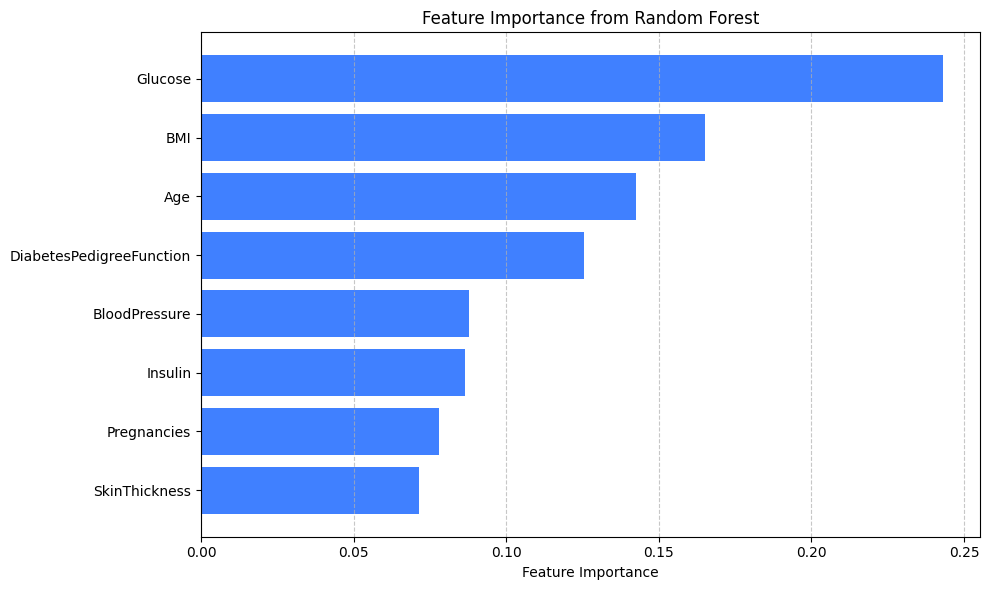

In [15]:
X = abt_fi.drop(axis=1, columns='Outcome')
y = abt_fi.Outcome

# Treinar modelo com algoritmo Random Forest (Calma, não precisa focar no modelo neste momento)
clf = RandomForestClassifier() # troque aqui qual classificador quer utilizar: GradientBoostingClassifier, DecisionTreeClassifier
clf.fit(X, y)

# Obter importância das variáveis
feature_importances = clf.feature_importances_
features = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
})

#' Ordenar variáveis por importância
features = features.sort_values(by='Importance', ascending=False)

# Estabelecer um limite de corte, por exemplo, x% da importância máxima
cutoff_maximp = 0.6

cutoff = cutoff_maximp * feature_importances.max()

# Selecionar variáveis acima do corte
selected_features = X.columns[feature_importances > cutoff].tolist()
selected_features
# Visualizando a importância das variáveis em barras horizontais

plt.figure(figsize=(10, 6))
sorted_idx = feature_importances.argsort()

plt.barh(X.columns[sorted_idx], feature_importances[sorted_idx], color=(0.25, 0.5, 1))  # tom de azul claro
plt.xlabel("Feature Importance")
plt.title("Feature Importance from Random Forest")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [16]:
# Mantendo somente as variáveis selecionadas na ABT
abt_01 = abt_fi[selected_features + ['Outcome']]

abt_01.head()

,Glucose,BMI,Outcome
729,-0.912771,-0.257693,0
482,-1.127582,-0.545758,0
507,0.253345,-0.445562,0
439,-0.452462,0.581455,0
365,-0.697960,0.230767,0


## Recursive Feature Elimination (RFE)

In [17]:
# Cópia para RFE
abt_rfe = abt_model.copy()
abt_rfe.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
729,-0.535840,-0.912771,-0.907037,-1.299161,-0.684522,-0.257693,-0.984552,-0.976477,0
482,0.055897,-1.127582,-0.595298,0.064085,-0.267781,-0.545758,-0.493640,-0.460359,0
507,-0.831708,0.253345,-0.491386,0.126051,0.761316,-0.445562,0.654797,-1.062496,0
439,0.647634,-0.452462,0.963393,-1.299161,-0.684522,0.581455,0.758929,-0.202300,0
365,0.351765,-0.697960,-0.803124,0.435879,0.021387,0.230767,0.080578,-0.288320,0


In [18]:
# Separar as variáveis independentes (X) e a variável dependente (y)
X_rfe = abt_rfe.drop(columns=['Outcome'])
y_rfe = abt_rfe['Outcome']

# Instanciar o modelo de regressão logística com mais iterações
model = LogisticRegression(max_iter=2000)

# Instanciar o RFE com o modelo e o número desejado de features
rfe = RFE(estimator=model, n_features_to_select=5)

# Ajustar o RFE aos dados
rfe = rfe.fit(X_rfe, y_rfe)

# Obter as variáveis selecionadas
selected_features_rfe = X_rfe.columns[rfe.support_].tolist()
print('Selected features by RFE:', selected_features_rfe)

# Criar um novo dataframe com as variáveis selecionadas
abt_rfe_selected = abt_rfe[selected_features_rfe + ['Outcome']]
abt_rfe_selected.head()

Selected features by RFE: ['Pregnancies', 'Glucose', 'BMI', 'DiabetesPedigreeFunction', 'Age']


,Pregnancies,Glucose,BMI,DiabetesPedigreeFunction,Age,Outcome
729,-0.535840,-0.912771,-0.257693,-0.984552,-0.976477,0
482,0.055897,-1.127582,-0.545758,-0.493640,-0.460359,0
507,-0.831708,0.253345,-0.445562,0.654797,-1.062496,0
439,0.647634,-0.452462,0.581455,0.758929,-0.202300,0
365,0.351765,-0.697960,0.230767,0.080578,-0.288320,0


## Boruta

In [19]:
# Cópia para Boruta
abt_boruta = abt_model.copy()

In [20]:
# Separar as variáveis independentes (X) e a variável dependente (y)
X_boruta = abt_boruta.drop(columns=['Outcome'])
y_boruta = abt_boruta['Outcome']

# Instanciar o modelo de Random Forest
rf = RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=5)

# Instanciar o Boruta
boruta = BorutaPy(estimator=rf, n_estimators='auto', verbose=2, random_state=1)

# Ajustar o Boruta aos dados
boruta.fit(X_boruta.values, y_boruta.values)

# Obter as variáveis selecionadas
selected_features_boruta = X_boruta.columns[boruta.support_].tolist()
print('Selected features by Boruta:', selected_features_boruta)

# Criar um novo dataframe com as variáveis selecionadas
abt_boruta_selected = abt_boruta[selected_features_boruta + ['Outcome']]
abt_boruta_selected.head()

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	8
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	8
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	8
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	8
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	8
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	8
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	8
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	4
Tentative: 	2
Rejected: 	2
Iteration: 	9 / 100
Confirmed: 	4
Tentative: 	2
Rejected: 	2
Iteration: 	10 / 100
Confirmed: 	4
Tentative: 	2
Rejected: 	2
Iteration: 	11 / 100
Confirmed: 	4
Tentative: 	2
Rejected: 	2
Iteration: 	12 / 100
Confirmed: 	5
Tentative: 	1
Rejected: 	2
Iteration: 	13 / 100
Confirmed: 	5
Tentative: 	1
Rejected: 	2
Iteration: 	14 / 100
Confirmed: 	5
Tentative: 	1
Rejected: 	2
Iteration: 	15 / 100
Confirmed: 	5
Tentative: 	1
Rejected: 	2
Iteration: 	16 / 100
Confirmed: 	6
Tentative: 	0
Rejected: 	2


BorutaPy finish

,Pregnancies,Glucose,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
729,-0.535840,-0.912771,-0.684522,-0.257693,-0.984552,-0.976477,0
482,0.055897,-1.127582,-0.267781,-0.545758,-0.493640,-0.460359,0
507,-0.831708,0.253345,0.761316,-0.445562,0.654797,-1.062496,0
439,0.647634,-0.452462,-0.684522,0.581455,0.758929,-0.202300,0
365,0.351765,-0.697960,0.021387,0.230767,0.080578,-0.288320,0


## Pearson Correlation

In [21]:
# Cópia para Pearson
abt_pearson = abt_model.copy()

In [22]:
# Calcular a correlação de Pearson entre as features e a variável alvo
correlation_matrix = abt_pearson.corr()

# Selecionar as features que possuem uma correlação significativa com a variável alvo
correlation_threshold = 0.1  # Defina um limiar de correlação
significant_features = correlation_matrix.index[abs(correlation_matrix["Outcome"]) > correlation_threshold].tolist()

# Remover a variável alvo da lista de features significativas
significant_features.remove("Outcome")

# Criar um novo dataframe com as features selecionadas
abt_pearson_selected = abt_pearson[significant_features + ["Outcome"]]

print("Selected feature by Pearson:", significant_features)

# Exibir as primeiras linhas do novo dataframe
abt_pearson_selected.head()

Selected feature by Pearson: ['Pregnancies', 'Glucose', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']


,Pregnancies,Glucose,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
729,-0.535840,-0.912771,-0.684522,-0.257693,-0.984552,-0.976477,0
482,0.055897,-1.127582,-0.267781,-0.545758,-0.493640,-0.460359,0
507,-0.831708,0.253345,0.761316,-0.445562,0.654797,-1.062496,0
439,0.647634,-0.452462,-0.684522,0.581455,0.758929,-0.202300,0
365,0.351765,-0.697960,0.021387,0.230767,0.080578,-0.288320,0


## Corte por IV

In [23]:
# Cópia para IV
abt_iv = abt_model.copy()

In [24]:
def calculate_iv(df, feature, target, bins=10):
	"""
	Função para calcular o Information Value (IV) de uma variável.
	"""
	df = df[[feature, target]].copy()
	df['bin'] = pd.qcut(df[feature], bins, duplicates='drop')
	grouped = df.groupby('bin', observed=False)[target].agg(['count', 'sum'])
	grouped['non_event'] = grouped['count'] - grouped['sum']
	grouped['event_rate'] = grouped['sum'] / grouped['sum'].sum()
	grouped['non_event_rate'] = grouped['non_event'] / grouped['non_event'].sum()
	grouped['woe'] = np.log(grouped['event_rate'] / grouped['non_event_rate'])
	grouped['iv'] = (grouped['event_rate'] - grouped['non_event_rate']) * grouped['woe']
	iv = grouped['iv'].sum()
	return iv

# Calcular o IV para cada variável
iv_values = {}
target = 'Outcome'
for feature in abt_iv.columns:
	if feature != target:
		iv = calculate_iv(abt_iv, feature, target)
		iv_values[feature] = iv

# Definir um limiar de corte para o IV
iv_threshold = 0.1

# Selecionar as variáveis cujo IV é maior que o limiar definido
selected_features_iv = [feature for feature, iv in iv_values.items() if iv > iv_threshold]
print('Selected features by IV:', selected_features_iv)

# Criar um novo dataframe com as variáveis selecionadas
abt_iv_selected = abt_iv[selected_features_iv + [target]]
abt_iv_selected.head()

Selected features by IV: ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
729,-0.535840,-0.912771,-0.907037,-1.299161,-0.684522,-0.257693,-0.984552,-0.976477,0
482,0.055897,-1.127582,-0.595298,0.064085,-0.267781,-0.545758,-0.493640,-0.460359,0
507,-0.831708,0.253345,-0.491386,0.126051,0.761316,-0.445562,0.654797,-1.062496,0
439,0.647634,-0.452462,0.963393,-1.299161,-0.684522,0.581455,0.758929,-0.202300,0
365,0.351765,-0.697960,-0.803124,0.435879,0.021387,0.230767,0.080578,-0.288320,0


## PCA + IV

In [25]:
# Cópia para PCA+IV
abt_pca_iv = abt_model.copy()

In [26]:
# Calcular o IV para cada variável
iv_values_pca = {}
target = 'Outcome'
for feature in abt_pca_iv.columns:
	if feature != target:
		iv = calculate_iv(abt_pca_iv, feature, target)
		iv_values_pca[feature] = iv

# Definir um limiar de corte para o IV
iv_threshold_pca = 0.1

# Selecionar as variáveis cujo IV é maior que o limiar definido
selected_features_iv_pca = [feature for feature, iv in iv_values_pca.items() if iv > iv_threshold_pca]
print('Selected features by IV:', selected_features_iv_pca)

# Criar um novo dataframe com as variáveis selecionadas
abt_iv_pca_selected = abt_pca_iv[selected_features_iv_pca]

# Separar as variáveis independentes (X) e a variável dependente (y)
X_iv_pca = abt_iv_pca_selected
y_iv_pca = abt_pca_iv[target]

# Aplicar PCA
pca = PCA(n_components=5)  # Defina o número de componentes principais desejado
X_pca = pca.fit_transform(X_iv_pca)

# Criar um novo dataframe com as componentes principais
pca_columns = [f'PC{i+1}' for i in range(X_pca.shape[1])]
abt_pca_iv_selected = pd.DataFrame(X_pca, columns=pca_columns)
abt_pca_iv_selected[target] = y_iv_pca.values

# Exibir as primeiras linhas do novo dataframe
abt_pca_iv_selected.head()

Selected features by IV: ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']


,PC1,PC2,PC3,PC4,PC5,Outcome
0,-2.171885,-0.636040,0.237673,-0.523993,-0.220866,0
1,-1.192179,-0.449258,0.403554,0.178812,0.797643,0
2,0.069914,-1.501907,-0.932645,0.022544,-0.085380,0
3,-0.232291,0.797130,0.515746,0.908966,-1.102944,0
4,-0.230269,-0.443865,0.146966,0.435220,0.851185,0


# Comparação das técnicas

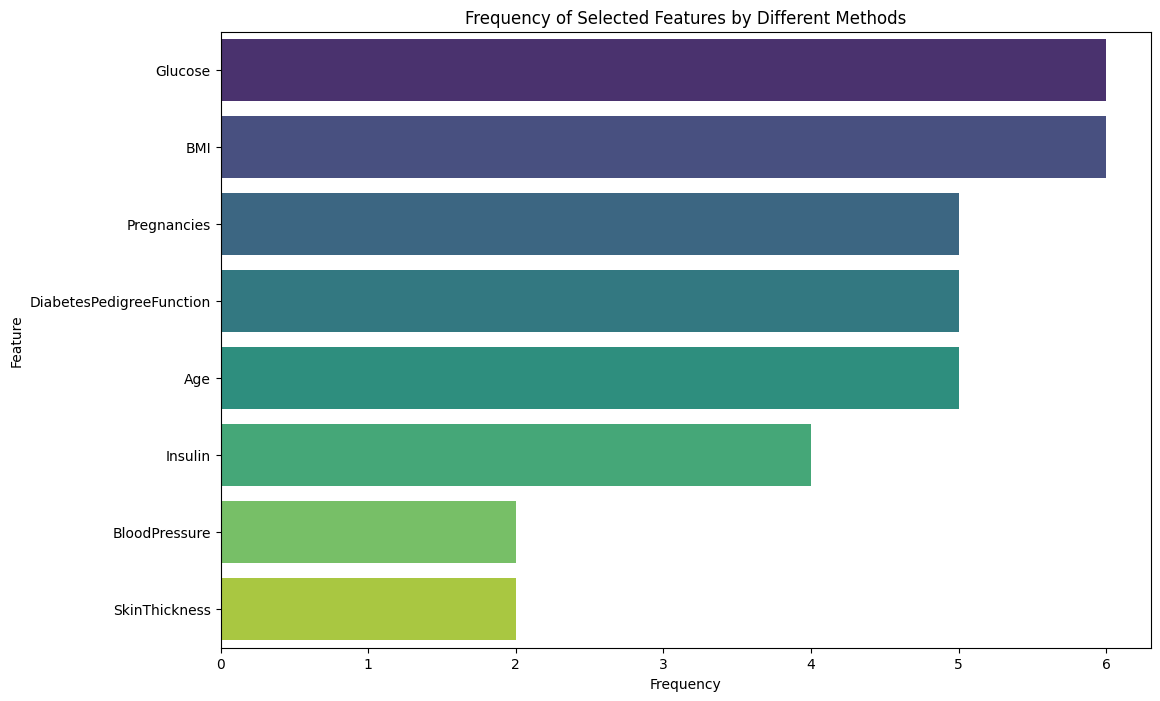

RFE: 5
Boruta: 5
IV: 5
Pearson: 5
PCA + IV: 5
Feature Importance: 2


In [27]:
# Variáveis selecionadas por cada método
selected_features_dict = {
	'Feature Importance': selected_features,
	'RFE': selected_features_rfe,
	'Boruta': selected_features_boruta,
	'IV': selected_features_iv,
	'Pearson': significant_features,
	'PCA + IV': selected_features_iv_pca
}

# Contar a frequência de cada variável
all_selected_features = [feature for features in selected_features_dict.values() for feature in features]
feature_counts = Counter(all_selected_features)

# Criar um DataFrame para facilitar a visualização
feature_counts_df = pd.DataFrame.from_dict(feature_counts, orient='index', columns=['Frequency']).reset_index()
feature_counts_df.columns = ['Feature', 'Frequency']

# Plotar o histograma de frequência
plt.figure(figsize=(12, 8))
sns.barplot(data=feature_counts_df.sort_values(by='Frequency', ascending=False), x='Frequency', y='Feature', hue='Feature', palette='viridis', legend=False)
plt.title('Frequency of Selected Features by Different Methods')
plt.xlabel('Frequency')
plt.ylabel('Feature')
plt.show()

# Listar as técnicas em ordem de qual selecionou o maior número do top 5 de variáveis mais selecionadas
top_5_features = feature_counts_df.sort_values(by='Frequency', ascending=False).head(5)['Feature'].tolist()
technique_counts = {technique: len(set(features) & set(top_5_features)) for technique, features in selected_features_dict.items()}
sorted_techniques = sorted(technique_counts.items(), key=lambda item: item[1], reverse=True)

# Exibir a lista em ordem
for technique, count in sorted_techniques:
	print(f"{technique}: {count}")


Temos aqui uma comparação de quais variáveis foram escolhidas e quantas vezes por cada técnica, assim temos uma "opnião diferente" para quais variáveis são realmente relevantes para o comportamento do Target, nesse caso a sobrevivência dos tripulantes. Além disso, abaixo do gráfico há quais técnicas de feature selection selecionaram o top-5 das variáveis escolhidas, indicando boas técnicas para serem utilizadas.